In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import apportionment.methods as app
import os

import warnings
warnings.filterwarnings('ignore')

Load in the base simulation data to get `COP` and `NPV`.

In [2]:
baseSim = pd.read_excel('../DSSG2023-Heating-Loads-Data/alanMitchellData/simulation_data/results_baseCase.xlsx', index_col = 0)

In [3]:
baseSim.columns

Index(['City', 'Exist_Fuel_Type', 'Scenario', 'Census_Area', 'ANCSA_Region',
       'Util_Name', 'PCE', 'Sq_Ft', 'Capital_Cost', 'Elec_Use_Jan',
       'Elec_Use_May', 'Design_Heat_Load', 'Design_Heat_Temp', 'COP',
       'Max_HP_Cap_Reached', 'HP_Load_Frac', 'IRR', 'NPV', 'CO2_lbs_saved',
       'CO2_driving_miles_saved', 'Fuel_Use_Chg', 'Fuel_Price_Incremental',
       'Elec_Use_Chg', 'Elec_Rate_Incremental', 'Econ', 'Exist_Fuel'],
      dtype='object')

In [4]:
baseSim = baseSim[['City', 'Census_Area', 'COP', 'NPV']]
baseSim.head()

,City,Census_Area,COP,NPV
0,Adak,Aleutians West Census Area,2.788967,97267.257504
1,Adak,Aleutians West Census Area,2.788967,-24239.879593
2,Akhiok,Kodiak Island Borough,2.755018,150840.269410
3,Akhiok,Kodiak Island Borough,2.755018,4235.484352
4,Akhiok,Kodiak Island Borough,2.755018,-49463.228663


In [5]:
baseSim.replace({'Census_Area': {'Anchorage municipality': 'Anchorage Municipality', 'Wade Hampton Census Area': 'Kusilvak Census Area'}}, inplace=True)

In [6]:
boroughCOP = baseSim.groupby(['Census_Area']).mean(numeric_only = True)

In [7]:
boroughCOP.min()

COP       2.454104
NPV    9592.453388
dtype: float64

In [8]:
boroughCOP.max()

COP        2.760865
NPV    32385.720387
dtype: float64

In [9]:
# boroughCOP.sort_values(by = 'COP')

Load in the borough shapefile to get `HOUSEUNITS`

In [10]:
boroughs = gpd.read_file('../DSSG2023-Heating-Loads-Data/shapefiles/Boroughs2020/Boroughs2020.shp')

In [11]:
boroughs.columns

Index(['NAME', 'STATE', 'BOROUGH', 'FIPS', 'TOTALPOP', 'WHITE', 'BLACK',
       'NATIVE', 'ASIAN', 'PACISLAND', 'OTHER', 'TWO_PLUS', 'HISPANIC',
       'NATALNCOMB', 'GRPQTRS', 'HOUSEUNITS', 'VACANT', 'OCCUPIED',
       'geometry'],
      dtype='object')

Combine two boroughs into one. See why [here](https://www.census.gov/programs-surveys/geography/technical-documentation/county-changes/2010.html)

In [12]:
boroughs = boroughs[['NAME', 'TOTALPOP', 'HOUSEUNITS']]
vc_pop = 7102 + 2617
vc_hu = 3565 + 2769
boroughs.loc[len(boroughs.index)] = ['Valdez-Cordova Census Area', vc_pop, vc_hu] 

Join the two datasets. 

In [13]:
df = boroughs.merge(boroughCOP, left_on='NAME', right_on='Census_Area', how = 'right')
df = df.drop_duplicates()
assert(df.shape[0] == 29)
df.head()

,NAME,TOTALPOP,HOUSEUNITS,COP,NPV
0,Aleutians East Borough,3420.0,679.0,2.729650,29806.789626
1,Aleutians West Census Area,5232.0,1331.0,2.744172,23640.821918
2,Anchorage Municipality,291247.0,118640.0,2.553543,17020.029265
3,Bethel Census Area,18666.0,5984.0,2.520064,21467.996840
4,Bristol Bay Borough,844.0,857.0,2.578357,32385.720387


<AxesSubplot: >

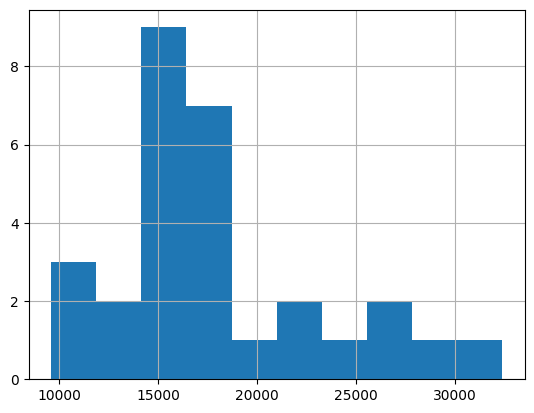

In [14]:
df['NPV'].hist(bins=10)

<AxesSubplot: >

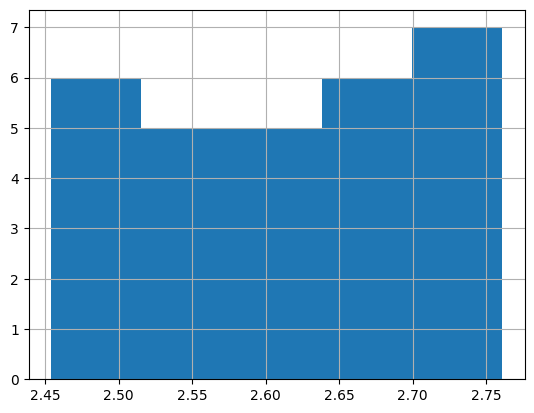

In [15]:
df['COP'].hist(bins=5)

<AxesSubplot: >

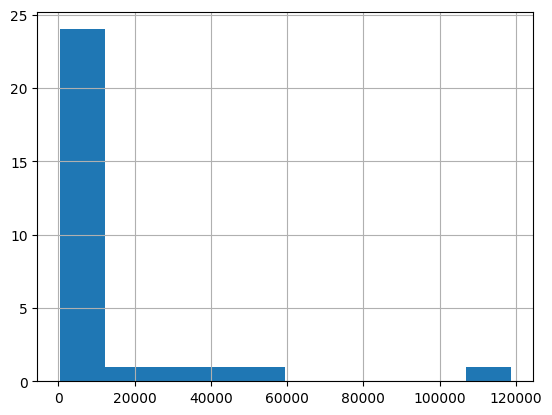

In [16]:
df['HOUSEUNITS'].hist()

In [17]:
total_hu = df['HOUSEUNITS'].sum()
total_hu

326200.0

In [18]:
df['hp_current'] = [0, 0, 134, 0, 0, 2, 0, 124, 0, 0, 2000, 66, 0, 0, 0, 0, 66, 0, 0, 76, 0, 0, 0, 0, 8, 
                    0, 0, 0, 0]

current_hp = df['hp_current'].sum()
current_hp

2476

In [19]:
adoption_rates = [0.02, 0.15]

for r in adoption_rates:
    print(r * total_hu)
    
hp_two_percent_goal = 6524
hp_15_percent_goal = 48930

hp_2p_additional_needed = hp_two_percent_goal - current_hp
hp_15p_additional_needed = hp_15_percent_goal - current_hp

6524.0
48930.0


## Exploration 1: Rank the heat pump efficiency and use that for the vote proxy to distribute heat pumps to 2% of the state's housing units

Look for possible problems, see if the algo runs

In [20]:
df_ranked = df.rank(numeric_only = True)
df_ranked['NAME'] = df['NAME']
df_ranked.head()

,TOTALPOP,HOUSEUNITS,COP,NPV,hp_current,NAME
0,10.0,2.0,25.0,28.0,11.0,Aleutians East Borough
1,12.0,6.0,26.0,25.0,11.0,Aleutians West Census Area
2,29.0,29.0,11.0,16.0,28.0,Anchorage Municipality
3,24.0,22.0,7.0,23.0,11.0,Bethel Census Area
4,2.0,4.0,12.0,29.0,11.0,Bristol Bay Borough


In [21]:
boroughsList = df['NAME'].to_list()
COPList = df_ranked['COP'].to_list()
additional_hp_2p = app.compute('dhondt', COPList, hp_2p_additional_needed, boroughsList)

In [22]:
adoption = df.copy()
adoption['hp_2p'] = adoption['hp_current'] + additional_hp_2p 
adoption['hp_2p_b_prop'] = adoption['hp_2p'] / adoption['HOUSEUNITS']
adoption['hp_2p_total_prop'] = adoption['hp_2p'] / total_hu
adoption['hp_2p_total_prop'].sum()

0.019999999999999997

## Exploration 2: As above, distribute additional heat pumps needed to get to the statewide 15% adoption goal.

In [23]:
additional_hp_15p = app.compute('dhondt', COPList, hp_15p_additional_needed, boroughsList)

The below will distribute 15% adoption but it will oversaturate some boroughs (i.e. their adoption rate is > 100%)

In [24]:
adoption['hp_15p'] = adoption['hp_current'] + additional_hp_15p 
adoption['hp_15p_b_prop'] = adoption['hp_15p'] / adoption['HOUSEUNITS']
print(adoption['hp_15p_b_prop'])
adoption['hp_15p_total_prop'] = adoption['hp_15p'] / total_hu
print(adoption['hp_15p_total_prop'].sum())

0     3.932253
1     2.086401
2     0.011033
3     0.124833
4     1.494749
5     0.599626
6     0.577131
7     0.015425
8     1.559124
9     1.262240
10    0.278294
11    0.051131
12    0.355307
13    0.513476
14    0.364646
15    1.163376
16    0.030562
17    0.156288
18    0.081329
19    0.145749
20    1.429569
21    0.959715
22    0.696787
23    2.669737
24    0.123826
25    0.168614
26    2.013354
27    4.117914
28    0.026408
Name: hp_15p_b_prop, dtype: float64
0.15


To fix that, determine how many heat pumps are oversaturating those boroughs and redistribute to the unsaturated boroughs. repeat this process while any boroughs are oversaturated with heat pumps.

Note: setting a "vote count" to zero will distribute zero to that region.

## Exploration 3: Write a function to run the vote distribution algorithm multiple times ensuring no borough gets more heat pumps than housing units.

Some things that have been added in from above:
- `method`: do you rank or do you normalize?
- `saturated_threshold`: at what point does a borough have the maximum plausible number of heat pumps it can have?

In [25]:
def redistribute_hp_by_cop(input_df, hp_to_distribute, method = 'rank1', saturated_threshold = 1):
    '''
    return a series where hp_to_distribute have been distributed for each row of input_df
    
    Keyword args:
    input_df: a dataframe with columns NAME, COP, and hp_current
    hp_to_distribute: the number of additional heat pumps to distribute
    method: one of 'rank1', 'rank2', or 'normalize'
        'rank1': ranks HP efficiency at every iteration
        'rank2' ranks HP efficiency once at the beginning of the function. once a borough becomes saturated its 
                associated rank becomes zero
        'normalize': noramlize HP efficiency to be between 0 and 1, then transform to get larger whole numbers
    '''
    df = input_df.copy()
    df['HOUSEUNITS_MAX'] = df['HOUSEUNITS'] * saturated_threshold
    
    boroughsList = df['NAME'].to_list()
    
    if method == 'normalize':
        # normalize COP and make COPList
        temp = ((df['COP'] - df['COP'].min()) / (df['COP'].max() - df['COP'].min())).to_list()
        # add one to ensure the min still gets some heat pumps (zero leads to zero distribution) 
        COPList = [round((x + 1) * 100) for x in temp]
    elif method == 'rank2':
        df_ranked = df.rank(numeric_only=True)
        df_ranked['NAME'] = df['NAME']
        df_ranked.loc[df_ranked['COP'].isnull(), 'COP'] = 0
        COPList = df_ranked['COP'].to_list()
        
    # distribute heat pumps     
    while True:
        # get the variables needed for algorithm
        if method == 'rank1':
            df_ranked = df.rank(numeric_only=True) #rerank the efficiency every iteration
            df_ranked['NAME'] = df['NAME']
            df_ranked.loc[df_ranked['COP'].isnull(), 'COP'] = 0
            COPList = df_ranked['COP'].to_list()
        # get the number of heat pumps distributed to each borough
        additional_hp = app.compute('dhondt', COPList, hp_to_distribute, boroughsList)
        
        # calculate total number of heat pumps in each borough and the saturation within a borough
        df['distributed_hp'] = df['hp_current'] + additional_hp
        df['distributed_hp_b_prop'] = df['distributed_hp'] / df['HOUSEUNITS_MAX']
                
        mask = df['distributed_hp_b_prop'] > 1
        oversaturated = mask.any()
        # return if all heat pumps have been distributed without over saturating any borough
        if not oversaturated:
            return df['distributed_hp']       
    
        # set COPList appropriately for boroughs that got over saturated
        if method == 'rank1':
            df.loc[mask, 'COP'] = np.nan
        else:
            temp = COPList and ~mask
            COPList = [a*b for a,b in zip(temp,COPList)] 

        hp_to_distribute = round(sum(df[df['distributed_hp_b_prop'] >= 1]['distributed_hp'] - df[df['distributed_hp_b_prop'] >= 1]['HOUSEUNITS_MAX']))
        # update the number of heat pumps in the boroughs to be min(HU, distributed_hp)
        # this prevents boroughs from being allocated more heat pumps than they have housing units
        df['hp_current'] = df[['HOUSEUNITS_MAX', 'distributed_hp']].min(axis=1)


In [26]:
hp_15p_r1 = redistribute_hp_by_cop(df, hp_15p_additional_needed, 'rank1') 
hp_15p_r1

0      679.0
1     1331.0
2     1944.0
3     1151.0
4      857.0
5     1483.0
6     2081.0
7      946.0
8     1370.0
9     1777.0
10    4789.0
11    2476.0
12    3275.0
13    4031.0
14    1316.0
15    1469.0
16    2312.0
17     986.0
18     328.0
19     569.0
20    1718.0
21    3227.0
22    3867.0
23     760.0
24     665.0
25    1646.0
26    1273.0
27     441.0
28     163.0
Name: distributed_hp, dtype: float64

In [27]:
hp_15p_r2 = redistribute_hp_by_cop(df, hp_15p_additional_needed, 'rank2') 
hp_15p_r2

0      679.0
1     1331.0
2     1848.0
3     1089.0
4      857.0
5     1404.0
6     2026.0
7      901.0
8     1370.0
9     1777.0
10    4806.0
11    2403.0
12    3429.0
13    4364.0
14    1246.0
15    1469.0
16    2247.0
17     933.0
18     310.0
19     542.0
20    1718.0
21    3227.0
22    4139.0
23     760.0
24     630.0
25    1557.0
26    1273.0
27     441.0
28     154.0
Name: distributed_hp, dtype: float64

In [28]:
hp_15p_norm = redistribute_hp_by_cop(df, hp_15p_additional_needed, 'normalize') 
hp_15p_norm

0      679.0
1     1331.0
2     1876.0
3     1608.0
4      857.0
5     1606.0
6     1873.0
7     1627.0
8     1370.0
9     1777.0
10    4203.0
11    1966.0
12    2362.0
13    2613.0
14    1622.0
15    1469.0
16    1952.0
17    1503.0
18    1319.0
19    1435.0
20    1718.0
21    2640.0
22    2585.0
23     760.0
24    1432.0
25    1714.0
26    1273.0
27     441.0
28    1319.0
Name: distributed_hp, dtype: float64

In [29]:
adoption15 = df.copy()
adoption15['hp_15p_r1'] = hp_15p_r1
adoption15['hp_15p_r1_prop'] = hp_15p_r1 / total_hu
adoption15['hp_15p_r1_prop_b'] = hp_15p_r1 / adoption15['HOUSEUNITS']
adoption15['hp_15p_r2'] = hp_15p_r2
adoption15['hp_15p_r2_prop'] = hp_15p_r2 / total_hu
adoption15['hp_15p_r2_prop_b'] = hp_15p_r2 / adoption15['HOUSEUNITS']
adoption15['hp_15p_norm'] = hp_15p_norm
adoption15['hp_15p_norm_prop'] = hp_15p_norm / total_hu
adoption15['hp_15p_norm_prop_b'] = hp_15p_norm / adoption15['HOUSEUNITS']
adoption15.drop('TOTALPOP', axis = 1)

,NAME,HOUSEUNITS,COP,NPV,hp_current,hp_15p_r1,hp_15p_r1_prop,hp_15p_r1_prop_b,hp_15p_r2,hp_15p_r2_prop,hp_15p_r2_prop_b,hp_15p_norm,hp_15p_norm_prop,hp_15p_norm_prop_b
0,Aleutians East Borough,679.0,2.729650,29806.789626,0,679.0,0.002082,1.000000,679.0,0.002082,1.000000,679.0,0.002082,1.000000
1,Aleutians West Census Area,1331.0,2.744172,23640.821918,0,1331.0,0.004080,1.000000,1331.0,0.004080,1.000000,1331.0,0.004080,1.000000
2,Anchorage Municipality,118640.0,2.553543,17020.029265,134,1944.0,0.005960,0.016386,1848.0,0.005665,0.015577,1876.0,0.005751,0.015813
3,Bethel Census Area,5984.0,2.520064,21467.996840,0,1151.0,0.003529,0.192346,1089.0,0.003338,0.181985,1608.0,0.004929,0.268717
4,Bristol Bay Borough,857.0,2.578357,32385.720387,0,857.0,0.002627,1.000000,857.0,0.002627,1.000000,857.0,0.002627,1.000000
5,Denali Borough,1606.0,2.542613,14919.505128,2,1483.0,0.004546,0.923412,1404.0,0.004304,0.874222,1606.0,0.004923,1.000000
6,Dillingham Census Area,2405.0,2.583191,21606.673683,0,2081.0,0.006380,0.865281,2026.0,0.006211,0.842412,1873.0,0.005742,0.778794
7,Fairbanks North Star Borough,42659.0,2.496391,9592.453388,124,946.0,0.002900,0.022176,901.0,0.002762,0.021121,1627.0,0.004988,0.038140
8,Haines Borough,1370.0,2.661706,13740.431503,0,1370.0,0.004200,1.000000,1370.0,0.004200,1.000000,1370.0,0.004200,1.000000
9,Hoonah-Angoon Census Area,1777.0,2.673986,17122.450905,0,1777.0,0.005448,1.000000,1777.0,0.005448,1.000000,1777.0,0.005448,1.000000


Thoughts: COP is distributed uniformly across the boroughs, so normalizing leads to a uniform distribution. We don't love this and think ranking is a more likely scenario.

## Exploration 4: Consider distributing heat pumps according to a measure that isn't uniformly distributed, like the net present value (NPV) of a heat pump

In [30]:
def redistribute_hp_by_npv(input_df, hp_to_distribute, method = 'rank1'):
    '''
    return a series where hp_to_distribute have been distributed for each row of input_df
    
    Keyword args:
    input_df: a dataframe with columns NAME, COP, NPV, and hp_current
    hp_to_distribute: the number of additional heat pumps to distribute
    method: one of 'rank1', 'rank2', or 'normalize'
        'rank1': ranks HP efficiency at every iteration
        'rank2' ranks HP efficiency once at the beginning of the function. once a borough becomes saturated its 
                associated rank becomes zero
        'normalize': noramlize HP efficiency to be between 0 and 1, then transform to get larger whole numbers
    '''
    df = input_df.copy()
    boroughsList = df['NAME'].to_list()
    
    if method == 'normalize':
        # normalize NPV and make NPVList
        temp = ((df['NPV'] - df['NPV'].min()) / (df['NPV'].max() - df['NPV'].min())).to_list()
        # add one to ensure the min still gets some heat pumps (zero leads to zero distribution) 
        NPVList = [round((x + 1) * 100) for x in temp]
    elif method == 'rank2':
        df_ranked = df.rank(numeric_only=True)
        df_ranked['NAME'] = df['NAME']
        df_ranked.loc[df_ranked['NPV'].isnull(), 'NPV'] = 0
        NPVList = df_ranked['NPV'].to_list()
        
    # distribute heat pumps     
    while True:
        if method == 'rank1':
            df_ranked = df.rank(numeric_only=True) #rerank the efficiency every iteration
            df_ranked['NAME'] = df['NAME']
            df_ranked.loc[df_ranked['NPV'].isnull(), 'NPV'] = 0
            NPVList = df_ranked['NPV'].to_list()
        # run the algorithm
        additional_hp = app.compute('dhondt', NPVList, hp_to_distribute, boroughsList)

        # calculate the total number of heat pumps by borough and the saturation levels
        df['distributed_hp'] = df['hp_current'] + additional_hp
        df['distributed_hp_b_prop'] = df['distributed_hp'] / df['HOUSEUNITS']
                
        mask = df['distributed_hp_b_prop'] > 1
        oversaturated = mask.any()
        # return the distribution when no boroughs are over saturated
        if not oversaturated:
            return df['distributed_hp']       
    
        # update NPV values for boroughs that got oversaturated
        if method == 'rank1':
            df.loc[mask, 'NPV'] = np.nan
        else:
            temp = NPVList and ~mask
            NPVList = [a*b for a,b in zip(temp,NPVList)] 

        hp_to_distribute = round(sum(df[df['distributed_hp_b_prop'] >= 1]['distributed_hp'] - df[df['distributed_hp_b_prop'] >= 1]['HOUSEUNITS']))
        # update the number of heat pumps in the boroughs to be min(HU, distributed_hp)
        # this prevents boroughs from being allocated more heat pumps than they have housing units
        df['hp_current'] = df[['HOUSEUNITS','distributed_hp']].min(axis=1)


In [31]:
hp_15p_r1_npv = redistribute_hp_by_npv(df, hp_15p_additional_needed, 'rank1') 
hp_15p_r1_npv

0      679.0
1     1331.0
2     2222.0
3     2983.0
4      857.0
5     1562.0
6     2405.0
7      254.0
8      662.0
9     1777.0
10    4459.0
11    1362.0
12    1163.0
13    3330.0
14    2327.0
15    1469.0
16    2021.0
17    3462.0
18    2619.0
19    2717.0
20    1428.0
21     263.0
22    1030.0
23     760.0
24     404.0
25    1822.0
26     529.0
27     441.0
28    2592.0
Name: distributed_hp, dtype: float64

In [32]:
hp_15p_r2_npv = redistribute_hp_by_npv(df, hp_15p_additional_needed, 'rank2') 
hp_15p_r2_npv

0      679.0
1     1331.0
2     2207.0
3     2980.0
4      857.0
5     1555.0
6     2405.0
7      252.0
8      647.0
9     1777.0
10    4462.0
11    1361.0
12    1166.0
13    3370.0
14    2332.0
15    1469.0
16    2009.0
17    3499.0
18    2619.0
19    2717.0
20    1425.0
21     258.0
22    1035.0
23     760.0
24     395.0
25    1814.0
26     517.0
27     441.0
28    2591.0
Name: distributed_hp, dtype: float64

In [33]:
hp_15p_norm_npv = redistribute_hp_by_npv(df, hp_15p_additional_needed, 'normalize') 
hp_15p_norm_npv

0      679.0
1     1331.0
2     1971.0
3     2101.0
4      857.0
5     1606.0
6     2115.0
7     1505.0
8     1370.0
9     1777.0
10    3866.0
11    1752.0
12    1686.0
13    2378.0
14    1865.0
15    1469.0
16    1862.0
17    2460.0
18    1907.0
19    2011.0
20    1700.0
21    1395.0
22    1672.0
23     760.0
24    1473.0
25    1754.0
26    1273.0
27     441.0
28    1894.0
Name: distributed_hp, dtype: float64

In [34]:
adoption_15p_npv = df.copy()
adoption_15p_npv['hp_15p_r1_npv'] = hp_15p_r1_npv
adoption_15p_npv['hp_15p_r1_npv_prop'] = hp_15p_r1_npv / total_hu
adoption_15p_npv['hp_15p_r1_npv_prop_b'] = hp_15p_r1_npv / adoption_15p_npv['HOUSEUNITS']
adoption_15p_npv['hp_15p_r2_npv'] = hp_15p_r2_npv
adoption_15p_npv['hp_15p_r2_npv_prop'] = hp_15p_r2_npv / total_hu
adoption_15p_npv['hp_15p_r2_npv_prop_b'] = hp_15p_r2_npv / adoption_15p_npv['HOUSEUNITS']
adoption_15p_npv['hp_15p_norm_npv'] = hp_15p_norm_npv
adoption_15p_npv['hp_15p_norm_npv_prop'] = hp_15p_norm_npv / total_hu
adoption_15p_npv['hp_15p_norm_npv_prop_b'] = hp_15p_norm_npv / adoption_15p_npv['HOUSEUNITS']

We don't like this distribution; the northern boroughs get too many heat pumps. Compare how similar rankings of NPV and COP are:

In [35]:
boroughs_ranked = df.rank(numeric_only = True)
boroughs_ranked['COP - NPV rank'] = boroughs_ranked['COP'] - boroughs_ranked['NPV']
boroughs_ranked[['COP', 'NPV', 'COP - NPV rank']]

,COP,NPV,COP - NPV rank
0,25.0,28.0,-3.0
1,26.0,25.0,1.0
2,11.0,16.0,-5.0
3,7.0,23.0,-16.0
4,12.0,29.0,-17.0
5,9.0,12.0,-3.0
6,13.0,24.0,-11.0
7,5.0,1.0,4.0
8,20.0,5.0,15.0
9,21.0,17.0,4.0


In [36]:
sum(boroughs_ranked['COP - NPV rank'].abs() < 5)

11

In [37]:
sum(boroughs_ranked['COP - NPV rank'].abs() < 15) - sum(boroughs_ranked['COP - NPV rank'].abs() < 5)

8

In [38]:
sum(boroughs_ranked['COP - NPV rank'].abs() < 30) - sum(boroughs_ranked['COP - NPV rank'].abs() < 15)

10

They are really quite different, 2/3 of the boroughs are greater than +/- 5 away in terms of rank.

## Exploration 5: What if you set the saturation level for boroughs? What if only 50% of house units in a borough can get heat pumps?

In [39]:
hp_15p_r1_50 = redistribute_hp_by_cop(df, hp_15p_additional_needed, 'rank1', 0.5) 
hp_15p_r2_50 = redistribute_hp_by_cop(df, hp_15p_additional_needed, 'rank2', 0.5) 
hp_15p_norm_50 = redistribute_hp_by_cop(df, hp_15p_additional_needed, 'normalize', 0.5) 

In [40]:
adoption_15p_cop_50 = df.copy()
adoption_15p_cop_50['hp_15p_r1_50'] = hp_15p_r1_50
adoption_15p_cop_50['hp_15p_r1_50_prop'] = hp_15p_r1_50 / total_hu
adoption_15p_cop_50['hp_15p_r1_50_prop_b'] = hp_15p_r1_50 / adoption_15p_npv['HOUSEUNITS']
adoption_15p_cop_50['hp_15p_r2_50'] = hp_15p_r2_50
adoption_15p_cop_50['hp_15p_r2_50_prop'] =hp_15p_r2_50 / total_hu
adoption_15p_cop_50['hp_15p_r2_50_prop_b'] = hp_15p_r2_50 / adoption_15p_npv['HOUSEUNITS']
adoption_15p_cop_50['hp_15p_norm_50'] = hp_15p_norm_50
adoption_15p_cop_50['hp_15p_norm_50_prop'] = hp_15p_norm_50 / total_hu
adoption_15p_cop_50['hp_15p_norm_50_prop_b'] = hp_15p_norm_50 / adoption_15p_npv['HOUSEUNITS']

More boroughs will saturate. 

Ok still don't like how high the northern boroughs are and that smaller boroughs saturate much faster than larger boroughs. Try to include houseunits in the weighting scheme for how heat pumps are distributed.

## Exploration 6: Include houseunits in the weighting scheme

We will also keep any decisions that were made from the above:
- use COP not NPV
- rank don't normalize

In [41]:
df2 = df.copy()
df2['COP x ln HU'] = df2['COP'] * np.log(df['HOUSEUNITS'])
df2['COP x norm(HU)'] = df2['COP'] * ((df['HOUSEUNITS'] - df['HOUSEUNITS'].min()) / (df['HOUSEUNITS'].max() - df['HOUSEUNITS'].min()))
df2_ranked = df2.rank(numeric_only = True)
df2_ranked['NAME'] = df2['NAME']
df2_ranked[['NAME', 'COP', 'COP x ln HU', 'COP x norm(HU)']].sort_values(by='COP x norm(HU)')
df2_ranked['new']= df2_ranked['COP x ln HU'] * df2_ranked['COP']
df2_ranked[['NAME', 'COP', 'COP x ln HU', 'COP x norm(HU)', 'new']].sort_values(by='COP x norm(HU)')
df2_ranked['COP x ln HU'] * df2_ranked['COP'].to_list()

0     100.0
1     312.0
2     319.0
3     133.0
4      24.0
5      45.0
6     195.0
7     130.0
8     140.0
9     273.0
10    450.0
11    405.0
12    506.0
13    672.0
14     88.0
15     96.0
16    392.0
17    108.0
18     16.0
19     27.0
20    322.0
21    609.0
22    594.0
23     57.0
24     64.0
25    200.0
26    240.0
27     17.0
28     17.0
Name: COP x ln HU, dtype: float64

In [42]:
def redistribute_hp_by_cop_and_pop(input_df, hp_to_distribute, method = 'rank1', saturated_threshold = 1):
    '''
    return a series where hp_to_distribute have been distributed for each row of input_df
    
    Keyword args:
    input_df: a dataframe with columns NAME, COP, and hp_current
    hp_to_distribute: the number of additional heat pumps to distribute
    method: one of 'rank1', 'rank2', or 'normalize'
        'rank1': ranks HP efficiency at every iteration
        'rank2' ranks HP efficiency once at the beginning of the function. once a borough becomes saturated its 
                associated rank becomes zero
        'normalize': noramlize HP efficiency to be between 0 and 1, then transform to get larger whole numbers
    '''
    df = input_df.copy()
    df['ln HU'] = np.log(df['HOUSEUNITS'])
    boroughsList = df['NAME'].to_list()
    
    df['HOUSEUNITS_MAX'] = df['HOUSEUNITS'] * saturated_threshold
    
    if method == 'rank2':
        df_ranked = df.rank(numeric_only=True)
        df_ranked['NAME'] = df['NAME']
        COPList = df_ranked['COP'] * df_ranked['ln HU'] * df_ranked['COP']
        
    # distribute heat pumps     
    while True:
        # update the COPList if reranking every iteration
        if method == 'rank1':
            df_ranked = df.rank(numeric_only=True) #rerank the efficiency every iteration
            df_ranked.loc[df_ranked['COP'].isnull(), 'COP'] = 0 #oversaturated = 0
            COPList = df_ranked['COP'] * df_ranked['ln HU'] * df_ranked['COP']
        # run the algorithm
        additional_hp = app.compute('dhondt', COPList, hp_to_distribute, boroughsList)
        
        # calculate the total number of heat pumps by borough and the saturation levels
        df['distributed_hp'] = df['hp_current'] + additional_hp
        df['distributed_hp_b_prop'] = df['distributed_hp'] / df['HOUSEUNITS_MAX']
        
                
        mask = df['distributed_hp_b_prop'] > 1
        oversaturated = mask.any()
        # return if heat pumps have been distributed without over saturating any boroughs
        if not oversaturated:
            return df['distributed_hp']       
    
        # update COPList for boroughs that were over saturated
        if method == 'rank1':
            df.loc[mask, 'COP'] = np.nan
        else:
            temp = COPList and ~mask
            COPList = [a*b for a,b in zip(temp,COPList)] 

        hp_to_distribute = round(sum(df[df['distributed_hp_b_prop'] >= 1]['distributed_hp'] - df[df['distributed_hp_b_prop'] >= 1]['HOUSEUNITS_MAX']))
        # update the number of heat pumps in the boroughs to be min(HU, distributed_hp)
        # this prevents boroughs from being allocated more heat pumps than they have housing units
        df['hp_current'] = df[['HOUSEUNITS_MAX','distributed_hp']].min(axis=1)


In [43]:
hp_15p_r1_pop_50 = redistribute_hp_by_cop_and_pop(df, hp_15p_additional_needed, 'rank1', 0.5)
hp_2p_r1_pop_50 = redistribute_hp_by_cop_and_pop(df, hp_2p_additional_needed, 'rank1', 0.5)

In [44]:
adoption_15p_cop_pop_50 = df.copy()
adoption_15p_cop_pop_50['hp_2p'] = hp_2p_r1_pop_50
adoption_15p_cop_pop_50['hp_2p_prop_b'] = hp_2p_r1_pop_50 / adoption_15p_cop_pop_50['HOUSEUNITS']
adoption_15p_cop_pop_50['hp_15p'] = hp_15p_r1_pop_50
adoption_15p_cop_pop_50['hp_15p_prop_b'] = hp_15p_r1_pop_50 / adoption_15p_cop_pop_50['HOUSEUNITS']
adoption_15p_cop_pop_50['hp_current_prop_b'] = adoption_15p_cop_pop_50['hp_current'] / adoption_15p_cop_pop_50['HOUSEUNITS']

In [45]:
export = adoption_15p_cop_pop_50[['NAME', 'hp_current', 'hp_current_prop_b', 'hp_2p', 'hp_2p_prop_b',
                         'hp_15p', 'hp_15p_prop_b']]
#export.to_csv('adoption_scenarios_by_cop_and_pop_max_50p_sat_pretty.csv')

In [46]:
export

,NAME,hp_current,hp_current_prop_b,hp_2p,hp_2p_prop_b,hp_15p,hp_15p_prop_b
0,Aleutians East Borough,0,0.000000,44,0.064801,339.5,0.500000
1,Aleutians West Census Area,0,0.000000,145,0.108941,665.5,0.500000
2,Anchorage Municipality,134,0.001129,260,0.002192,4213.0,0.035511
3,Bethel Census Area,0,0.000000,38,0.006350,1252.0,0.209225
4,Bristol Bay Borough,0,0.000000,20,0.023337,428.5,0.500000
5,Denali Borough,2,0.001245,28,0.017435,803.0,0.500000
6,Dillingham Census Area,0,0.000000,78,0.032432,1202.5,0.500000
7,Fairbanks North Star Borough,124,0.002907,148,0.003469,908.0,0.021285
8,Haines Borough,0,0.000000,100,0.072993,685.0,0.500000
9,Hoonah-Angoon Census Area,0,0.000000,174,0.097918,888.5,0.500000
